<a href="https://colab.research.google.com/github/leesuyee/mesoscale-connectivity-tutorial/blob/main/mesoscale_connectivity_coding_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do -

add 1 coding task for students to solve

add 1 opportunity for group discussion

# Mapping the Brain: Discovering How Brain Areas Connect

In this coding tutorial, we will analyze whole-brain anatomy data from the Allen Institute to identify patterns of connectivity between brain areas to infer the function of those connections.

The dataset was collected as part of the [Thalamus in the Middle project](https://www.allenneuraldynamics.org/projects/neural-dynamics-in-multi-regional-circuits-with-thalamus-in-the-middle) at the Allen Institute for Neural Dynamics.

---

Feb 13, 2025

Allen Institute Education and Engagement Activity

Su-Yee Lee, Mathew Summers, Nicholas Lusk, Saskia de Vries

# Set up environment

Run the code cells below to install the necessary packages.

**DO NOT RERUN THIS CELL**


In [1]:
# install packages
!pip install s3fs==2026.1.0 pandas==2.2.2 brainglobe-atlasapi==2.3.0 matplotlib==3.10.0 numpy==2.0.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2026.1.0 which is incompatible.


In [2]:
# import packages
import os
from pathlib import Path
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
import numpy as np
from brainglobe_atlasapi import BrainGlobeAtlas

# Clone github repo to access data folders
repo_url = "https://github.com/leesuyee/mesoscale-connectivity-tutorial.git" # github repo URL
repo_dir = "/content/mesoscale-connectivity-tutorial" # set up path

# Clone the repo if it hasn't been cloned yet
if not os.path.exists(repo_dir):
    print(f"Cloning repository from {repo_url}...")
    !git clone {repo_url} {repo_dir}
else:
    print(f"Repository already exists at {repo_dir}")

# Change working directory to repo root
os.chdir(repo_dir)
print("Cloned github repo" )

Cloning repository from https://github.com/leesuyee/mesoscale-connectivity-tutorial.git...
Cloning into '/content/mesoscale-connectivity-tutorial'...
remote: Enumerating objects: 2608, done.
remote: Counting objects: 100% (1739/1739), done.
remote: Compressing objects: 100% (1730/1730), done.
remote: Total 2608 (delta 21), reused 1714 (delta 7), pack-reused 869 (from 3)
Receiving objects: 100% (2608/2608), 61.38 MiB | 9.90 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (1696/1696), done.
Filtering content: 100% (1692/1692), 769.42 MiB | 22.86 MiB/s, done.
Cloned github repo


In [3]:
# Import Allen mouse atlas from data folder

# Path to the data folder
local_bg_dir = Path("/content/mesoscale-connectivity-tutorial/data/")

# Initialize atlas from the local folder
atlas = BrainGlobeAtlas(
    atlas_name="allen_mouse_25um",
    brainglobe_dir=local_bg_dir,
    check_latest=False  # disables network version check
)

# Check atlas shape
print(atlas.reference.shape)

(528, 320, 456)


In [4]:
# Class to load SmartSPIM data asset from S3
class load_data:
    """
    Minimal Colab-compatible loader for SmartSPIM data (CCF coordinates and region counts) streamed directly from S3

    Parameters
    ----------
    mouse_ID : str | int
        Mouse ID (e.g. 689305)

        bucket : str
        S3 bucket name (e.g. "s3://aind-open-data")

        anon : bool
        Whether to use anonymous credentials (e.g. True)

        prefer_stitched : bool
        Whether to prefer stitched data (e.g. True)

    Attributes
    ----------
    rootDir : str
        Resolved S3 path to the selected SmartSPIM dataset.

    quantPaths : dict[str, str]
        Mapping from imaging channel (e.g., ``"488"``) to the
        corresponding ``cell_count_by_region.csv`` file path.

    ccfCellsPaths : dict[str, str]
        Mapping from imaging channel to the corresponding
        ``transformed_cells.xml`` file path containing CCF
        coordinates.

    channels : list[str]
        Sorted list of available imaging channels discovered
        for the dataset.

    Methods
   ----------
   resolve_paths()
        Method to get path to whole brain volume data

    getCellsCCFdf(ch: list[str])
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

    getcellcounts(ch: list[str])
        Imports the cell_counts_by_region.csv as a DataFrame

    """

    def __init__(
        self,
        mouse_ID: str | int,
        bucket: str = "s3://aind-open-data",
        anon: bool = True,
        prefer_stitched: bool = True,
    ):
        self.mouse_ID = str(mouse_ID)
        self.bucket = bucket
        self.fs = s3fs.S3FileSystem(anon=anon)
        self.prefer_stitched = prefer_stitched

        self._resolve_paths()

    # Path resolution

    def _resolve_paths(self):
      """
      Method to get path to whole brain volume data
      """
      roots = self.fs.ls(self.bucket)
      matches = [r for r in roots if self.mouse_ID in r]

      if not matches:
          raise FileNotFoundError(f"No datasets found for mouse_ID {self.mouse_ID}")

      if self.prefer_stitched:
          stitched = [r for r in matches if "stitched" in r.lower()]
          if len(stitched) == 1:
              self.rootDir = stitched[0]
          elif len(stitched) > 1:
              raise ValueError(f"Multiple stitched datasets found: {stitched}")
          else:
              self.rootDir = matches[0]
      else:
          self.rootDir = matches[0]

      quant_dir = f"{self.rootDir}/image_cell_quantification"
      if not self.fs.exists(quant_dir):
          raise FileNotFoundError("image_cell_quantification directory not found")

      quant_paths = self.fs.glob(f"{quant_dir}/Ex*")

      self.quantPaths = {
          Path(p).name.split("_")[1]: f"{p}/cell_count_by_region.csv"
          for p in quant_paths
      }
      self.ccfCellsPaths = {
          Path(p).name.split("_")[1]: f"{p}/transformed_cells.xml"
          for p in quant_paths
      }

      self.channels = sorted(self.quantPaths.keys())

    # Cell coordinates in CCF

    def getCellsCCFdf(self, ch: list[str]):
        """
        Retrieves and formats CCF transformed coordinates of segmented cells into a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"])

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame cwhere each row is a cell and each column is a coordinate:
            AP (anterior-posterior), DV(dorsal-ventral), ML(medial-lateral),
            with an additional "channel column indicating the channel of origin
        """
        ccfDim = [528, 320, 456] # Allen mouse 25um atlas
        dfs = []

        for channel in ch:
            if channel not in self.ccfCellsPaths:
                raise KeyError(f"Channel {channel} not found")

            with self.fs.open(self.ccfCellsPaths[channel], "rb") as f:
                df = pd.read_xml(
                    f,
                    xpath="//CellCounter_Marker_File//Marker_Data//Marker_Type//Marker",
                )

            # export data in XYZ order and rename columns to AP, DV, ML
            df = (
                df[["MarkerX", "MarkerY", "MarkerZ"]]
                .rename(
                    columns={
                        "MarkerX": "AP",
                        "MarkerY": "DV",
                        "MarkerZ": "ML",
                    }
                )
                .assign(channel=channel)
            )
            # Clip coordinates within specified dimensions
            df["AP"] = df["AP"].clip(0, ccfDim[0] - 1)
            df["DV"] = df["DV"].clip(0, ccfDim[1] - 1)
            df["ML"] = df["ML"].clip(0, ccfDim[2] - 1)

            dfs.append(df)

        return pd.concat(dfs, ignore_index=True)

    # Cell counts by region

    def getcellcounts(self, ch: list[str]):
        """
        Imports the cell_counts_by_region.csv (quantifiction of detected cells in brain regions) as a DataFrame

        Parameters
        ----------
        ch : list[str]
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]

        Returns
        -------
        dfs : pd.DataFrame
            DataFrame where each row is a brain region cell count in a given channel
        """
        required_columns = [
            "ID", "Acronym", "Name", "Struct_Info", "Struct_area_um3",
            "Left", "Right", "Total",
            "Left_Density", "Right_Density", "Total_Density",
        ]

        # Initialize an empty list to hold DataFrames
        cell_counts_list = []

        for channel in ch:
            if channel not in self.quantPaths:
                raise KeyError(f"Channel {channel} not found")

            # Load csv
            with self.fs.open(self.quantPaths[channel], "rb") as f:
                df = pd.read_csv(f)

                # Check if all required columns are present
                if set(required_columns).issubset(df.columns):
                  # Truncate the DataFrame to specific columns
                  cell_counts = df[required_columns]
                  # Add a new column indicating the channel
                  cell_counts = cell_counts.assign(channel=channel)
                  # Append to list
                  cell_counts_list.append(cell_counts)

                # Throw error if missing columns
                if not set(required_columns).issubset(df.columns):
                    raise ValueError(f"Missing required columns in {channel}")

            # Concatenate list into a single DataFrame
            if cell_counts_list:
              cell_counts_df = pd.concat(cell_counts_list, ignore_index=True)
            else:
            # return empty DataFrame if no data is found
              cell_counts_df = pd.DataFrame(columns = required_columns + ["channel"])

        return cell_counts_df

# Load a data asset


In [5]:
mouse_ID = "689238" # Select a mouse ID
data = load_data(mouse_ID) # Load data
channels = data.channels # Get imaging channels (to do - maybe always extract all the channels)


# Cell Coordinates


**Automated Cell Detection**  

The dataset is comprised of reconstructed images of whole mouse brains with fluorescently labelled cells. Genetic strategies were used to identify and fluorescently tag cells that are connected. More specifically, this dataset is focused on connections between the thalamus and the frontal cortex. We can count the number of cells labelled in each brain area to construct a map of how different brain areas are connected. Comparing differences in how brain areas are connected can inform the function of these brain areas and different cell types within each brain area.

Manually counting these cells and identifying which brain area each cell is located in is quite laborious, especially at the whole brain scale. To facilitate this process, computational methods were developed to automatically detect the location of each cell. The rest of this tutorial will show how to load and analyze the spatial coordinates of these detected cells.
    
The `getCellsCCFdf` function loads the spatial coordinates of the detected cells in a given channel. The coordinates are provided in AP (anterior-posterior), DV (dorsal-ventral), and ML (medial-lateral) form.

to do:
  simplify content if possible
  schematics to add:
  brain with AP/DV/ML axes
  examples of cells in an image? maybe screenshots from neuroglancer?
  something to indicate automated cell detection

In [71]:
cell_coords = data.getCellsCCFdf(channels) # Get cell coordinate data
cell_coords

# to do - update function so that all possible channels are passed

,AP,DV,ML,channel
0,217,27,193,445
1,220,27,191,445
2,218,27,197,445
3,264,35,108,445
4,252,30,143,445
...,...,...,...,...
460598,306,267,370,561
460599,322,272,345,561
460600,311,275,360,561
460601,308,259,376,561


# Cell Counts x Brain Area

---

The cell coordinates are used to identify the brain area that each cell is in. The cell counts within each brain area are quantified and stored with each dataset. We can use the `getcellcounts` function to load a dataframe of the cell counts in each brain structure.

| Column    | Description |
| -------- | ------- |
| ID  | number id of brain structure   |
| Acronym | shorthand name of brain structure     |
| Name | full name of brain structure     |
| Struct_Info    | mid = structure crosses the midline, hemi = structure disconnected across midline  |
| Struct_area_um3   | volume of brain structure    |
| Left    | left hemisphere cell counts    |
| Right    | right hemisphere cell counts   |
| Total    | total cell counts   |
| Left_Density    | density of cells in left hemisphere of brain structure  |
| Right_Density    | density of cells in right hemisphere of brain structure  |
| Total_Density    | density of cells in total brain structure   |
| channel    | channel name    |


In [13]:
cell_counts_df = data.getcellcounts(channels) # Get brain areas cell counts data
cell_counts_df

,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel
0,997,root,root,mid,5.113271e+11,31285,146963,178248,1.223678e-07,5.748296e-07,3.485987e-07,445
1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,30906,145553,176459,1.336316e-07,6.293434e-07,3.814875e-07,445
2,567,CH,Cerebrum,hemi,1.414069e+11,30548,140365,170913,2.160290e-07,9.926318e-07,6.043304e-07,445
3,688,CTX,Cerebral cortex,hemi,1.137573e+11,30425,139934,170359,2.674553e-07,1.230110e-06,7.487826e-07,445
4,695,CTXpl,Cortical plate,hemi,1.093212e+11,30226,137780,168006,2.764880e-07,1.260323e-06,7.684055e-07,445
...,...,...,...,...,...,...,...,...,...,...,...,...
2509,129,V3,third ventricle,mid,1.139386e+09,11,203,214,1.930865e-08,3.563323e-07,1.878205e-07,561
2510,140,AQ,cerebral aqueduct,mid,4.506497e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2511,145,V4,fourth ventricle,mid,1.372785e+09,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2512,153,V4r,lateral recess,hemi,3.813698e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561


# Metadata

to do - describe metadata
probably should simplify the metadata CSV
maybe integrate this with the other data tables?
move this earlier?

In [8]:
# Load metadata CSV
csv_path = "metadata/metadata_filtered.csv"
metadata_df = pd.read_csv(csv_path)
metadata_df.head()

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,volume,age_days,days_to_perfusion,qc_tissue,ng_link,channel,qc_channel,ng_channel,ccf_ap,ccf_ml,ccf_dv,inj_structure,inj_parent
0,5,SmartSPIM_679519_2023-08-15_11-43-09_stitched_...,679519,Ai224(TICL-NLS-EGFP-ICF-NLS-dT)-hyg/wt,Male,AAVrg-Syn-Flpo,1.020000e+14,100.0,53,31,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,115.0,275.0,114.0,FRP6a,FRP
1,6,SmartSPIM_689237_2023-08-30_19-04-37_stitched_...,689237,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,50.0,52,21,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,139.0,244.0,96.0,ACAd5,ACAd
2,7,SmartSPIM_689237_2023-08-30_19-04-37_stitched_...,689237,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,50.0,52,21,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,140.0,295.0,86.0,MOs5,MOs
3,8,SmartSPIM_689238_2023-08-31_01-56-52_stitched_...,689238,wt/wt,Female,AAVrg-Syn-H2B-Turquoise,2.960000e+14,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,126.0,259.0,92.0,MOs5,MOs
4,9,SmartSPIM_689238_2023-08-31_01-56-52_stitched_...,689238,wt/wt,Female,AAVrg-Syn-H2B-tdTomato,5.100000e+13,50.0,52,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,122.0,237.0,138.0,ILA5,ILA


# Plot Heatmap of Cell Counts in Each Brain Area

to do - add some scientific questions to motivate plots

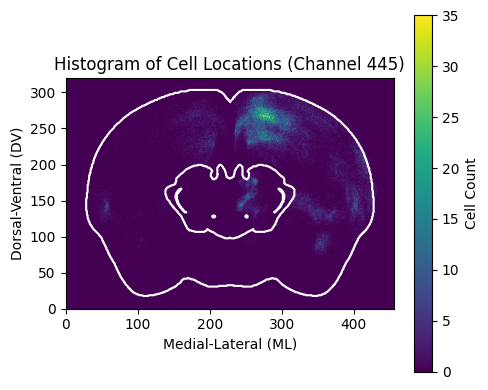

In [9]:
# Plot heatmap of cell counts in the brain
ch = '445' # select a channel
plane = 250 # anterior-posterior slice to plot
window = 100 # slice window bounds
roiList = ["root", "TH"] # brain structures to plot

# set figure parameters
fig, ax = plt.subplots(figsize=(5, 4))

cellLocs = ccf_df[ccf_df.channel == ch]
# generate the histogram of cell coordinates
planeLocs = cellLocs.loc[(cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :] # filter cellLocs to coordinates within AP slice bounds

# calculate bins for histogram
xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)

# create histogram of ML, DV coordinates
hist, xedges, yedges = np.histogram2d(
    planeLocs[planeLocs['channel'] == ch]["ML"],
    planeLocs[planeLocs['channel'] == ch]["DV"],
    bins=(xbins, ybins))

# overlay the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap = ax.imshow(
    hist.T,  # transpose because imshow expects (rows, cols)
    extent=extent,
    origin="upper",
    cmap="viridis",
    alpha=1)

# generate contour outlines for brain structures
for roi in roiList:
    roi_mask = atlas.get_structure_mask(roi) # creates a binary array the size of the brain, mask out brain structures of interest
    ax.contour(roi_mask[plane, :, :],
        levels=[0.5],
        colors="white",
        linewidths=1.5,
        origin="upper") # plotting features for structure outline

# add colorbar and labels
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Cell Count")
ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
ax.set_xlabel("Medial-Lateral (ML)")
ax.set_ylabel("Dorsal-Ventral (DV)")

plt.tight_layout()
plt.show()

# Compare Connectivity Across Brain Areas


To help us assess the connectivity across brain regions, we can use cell_counts_df to construct a connectivity matrix.  
    
First, filter the cell counts dataframe to cells within thalamic subregions. Here, we will use the acronym name and look at the leaf node structures (e.g. finest parcellated structures within thalamus). Next, use pivot_table to tabulate the connectivity matrix. Rows = channels, columns = brain structure, values = total cell counts

In [69]:
# thalamic subregions of interest (leaf nodes)
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList
filtered_cell_counts_df = cell_counts_df[cell_counts_df["Acronym"].isin(roiList)]

conn_mat = filtered_cell_counts_df.pivot_table(index = "channel",
                                      columns = "Acronym",
                                      values = "Total_Density")
conn_mat

Acronym,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,1.685543e-06,8.827668e-07,0.000002,1.530247e-08,1.312955e-06,1.889280e-06,4.066425e-08,1.072655e-07
488,2.231003e-06,1.843529e-06,0.000001,1.173189e-07,1.205803e-06,2.622491e-06,1.219927e-08,2.398848e-07
561,1.615312e-07,6.771424e-07,0.000001,3.978643e-07,7.805843e-07,1.163827e-08,2.419523e-06,2.387146e-06


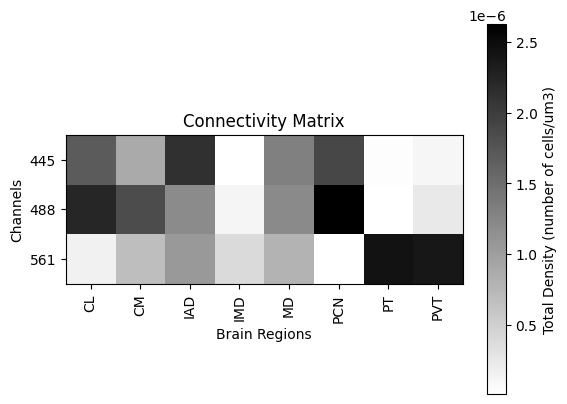

In [70]:
# plot the connectivity matrix as a heatmap

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="Total Density (number of cells/um3)")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Channels")
plt.show()

# to do - instead of channel numbers, use injection parent structure

In [62]:
# # option to plot across entire brain with a density cutoff

# filter_cell_counts_df = cell_counts_df[cell_counts_df.Total_Density >= cell_counts_df.Total_Density.describe()['75%']]

# conn_mat = filter_cell_counts_df.pivot_table(index = "channel",
#                                       columns = "Acronym",
#                                       values = "Total_Density")
# conn_mat

Acronym,ACA,ACAd,ACAd1,ACAd2/3,ACAd5,ACAd6a,ACAd6b,ACAv,ACAv1,ACAv2/3,...,lfbst,mfb,mfbc,mfbs,mfbse,mfsbshy,nst,root,scwm,sm
channel,,,,,,,,,,,,,,,,,,,,,
445,2.669167e-06,4.587180e-06,4.925991e-07,0.000006,5.507533e-06,5.739635e-06,2.925742e-07,NaN,NaN,NaN,...,NaN,4.777759e-07,NaN,NaN,3.406179e-07,2.259901e-07,NaN,3.485987e-07,4.415604e-07,NaN
488,1.341520e-06,2.250934e-06,2.591128e-07,0.000003,2.000909e-06,3.766675e-06,2.925742e-07,1.228681e-07,NaN,NaN,...,1.159289e-07,5.272010e-07,1.273452e-07,1.310574e-07,2.033786e-07,1.550727e-07,2.881644e-07,4.178636e-07,7.990438e-07,NaN
561,4.379250e-07,4.513203e-07,1.708436e-07,0.000001,2.632579e-07,2.309992e-07,NaN,4.147283e-07,1.244724e-07,5.103374e-07,...,NaN,4.448258e-07,NaN,NaN,3.852620e-07,2.600304e-07,NaN,1.341157e-07,NaN,3.268076e-07


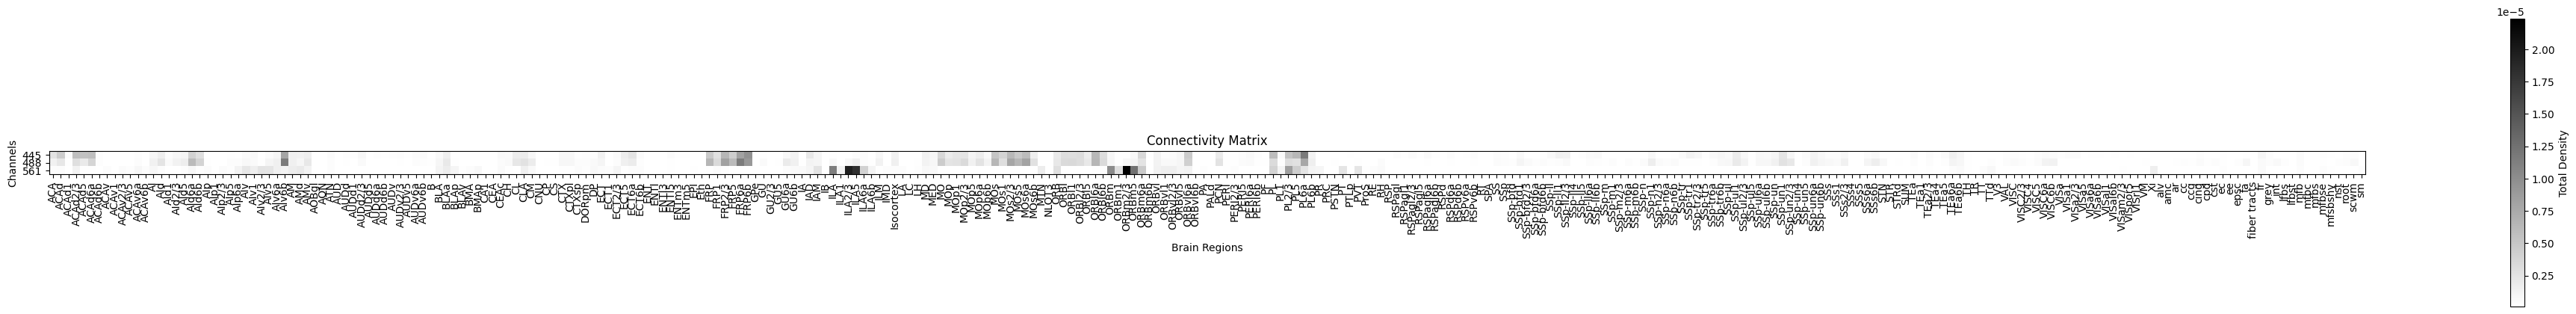

In [63]:
# plt.figure(figsize=(50,5))
# plt.imshow(conn_mat, cmap="gray_r")
# plt.colorbar(label="Total Density")
# plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
# plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
# plt.title("Connectivity Matrix")
# plt.xlabel("Brain Regions")
# plt.ylabel("Channels")
# plt.show()